1. Identifies the union set ATAC peaks

### Scipt Notes
1. 2022-09-19
    1. ILC1 was a previously used sample label that has been replaced by ex-ILC2 to more accuratly reflect the biology
    2. Window Size around Peaks == 20 based on average peak size

In [22]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
# import csv
import numpy as np
import pandas as pd
import glob
# import argparse
# import os
import time
# import datetime

# import pyBigWig #DOC: https://github.com/deeptools/pyBigWig (Written by deepTools co-author)
# import random


### mouse ILC2 and pcLC2 Data Details 

In [5]:
#Name of experiment condition 1
exp1_name = 'pcILC2'

#Name of experiment condition 2
exp2_name = 'ILC2'

#Number of replicates for condition 1
exp1_rep_num = 2

#Number of replicates for condition 2
exp2_rep_num = 3

# #Directory containing narrowPeak files for condition 1
# exp1_narrowPeak_dir = '/proj/dllab/jfoster/serody_project/results/macs2-Laurie_ATAC_2020-10-19_peakCalls/ILC1_rep*/'

# #Directory containing narrowPeak files for condition 2
# exp2_narrowPeak_dir = '/proj/dllab/jfoster/serody_project/results/macs2-Laurie_ATAC_2020-10-19_peakCalls/ILC2_rep*/'

# #Directory containing BAM files for condition 1
# exp1_bam_dir = '/proj/dllab/jfoster/serody_project/results/pipeline_output/atac-2020-10-16/ILC1_rep*/'

# #Directory containing BAM files for condition 2
# exp2_bam_dir = '/proj/dllab/jfoster/serody_project/results/pipeline_output/atac-2020-10-16/ILC2_rep*/'

# #Directory containing bigWig files for condition 1
# exp1_bw_dir = '/proj/dllab/jfoster/serody_project/results/pipeline_output/atac-2020-10-16/ILC1_rep*/'

# #Directory containing bigWig files for condition 2
# exp2_bw_dir = '/proj/dllab/jfoster/serody_project/results/pipeline_output/atac-2020-10-16/ILC2_rep*/'

# #Window size to put around ROE summit
win = 20

#### Output Directory

In [4]:
#Create Output Dir variable
output_dir = "./Figure_3/"


### Identification Experimental Condition 1 Union Set

#### Distribution of Exp1 NarrowPeak Sizes

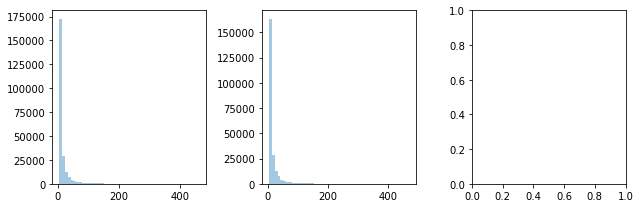

In [15]:
fn_exp1_narrowPeak = sorted(glob.glob('./processed_data/ILC1_ATAC_mouse_rep*narrowPeak'))

#Read narrowPeak files into pandas dataFrame
l_df_exp1_narrowPeak_size = [pd.read_csv(fn, sep = '\t', header = None) for fn in fn_exp1_narrowPeak]  

#Add names to df columns 
for df in l_df_exp1_narrowPeak_size:
    df.columns = ['chr', 'start', 'stop', 'peakName', 'score',
                  'na', 'foldChangeAtPeak', '-log10pvalue', '-log10qvalue', 'dist_to_summit']
    
#Calculate Peak sizes
exp1_narrow_peak_sizes = [df['stop'] - df['start'] for df in l_df_exp1_narrowPeak_size]

#Plot Peak sizes

fig, ax = plt.subplots(1,3, figsize=(9,3));

for idx, l_peak_sizes in enumerate(exp1_narrow_peak_sizes):
    
    sns.distplot(l_peak_sizes, ax = ax[idx], kde = False);

    plt.tight_layout()



#### Average Peak Size

In [16]:
#Print Descriptive statistics for Exp1 NarrowPeaks    
[pd.Series(list).describe() for list in exp1_narrow_peak_sizes]

#Print Average Peak sizes for three experiments 
exp1_narrowPeak_size_mean = pd.Series([pd.Series(list).describe()[1] for list in exp1_narrow_peak_sizes]).mean()

print(f'Average Peak size for Exp1: {exp1_narrowPeak_size_mean:.0f}')

Average Peak size for Exp1: 16


#### Define Union Set

In [18]:
################################
# Read in MACS2 narrowPeak files
################################

#Collect narrowPeak file names
fn_exp1_narrowPeak = sorted(glob.glob("./processed_data/ILC1_ATAC_mouse_rep*narrowPeak"))

#Read narrowPeak files into pandas dataFrame
l_df_exp1_narrowPeak = [pd.read_csv(fn, sep = '\t', header = None) for fn in fn_exp1_narrowPeak]   


###########################################
# Create summit files from narrowPeak files
###########################################

for df in l_df_exp1_narrowPeak:
    #Add names to df columns 
    df.columns = ['chr', 'start', 'stop', 'peakName', 'score',
                  'na', 'foldChangeAtPeak', '-log10pvalue', '-log10qvalue', 'dist_to_summit']
    
    #Identify the summit start coordinate
    df['start'] = df['start'] + df['dist_to_summit']
    
    #Identify the summit end coordinate
    df['stop'] = df['start'] + 1
    
    #Drop columns not need for downstream analysis 
    df.drop(columns = ['score', 'na', 'foldChangeAtPeak', '-log10qvalue', 'dist_to_summit'], inplace = True)
    
l_df_exp1_summit = l_df_exp1_narrowPeak


In [23]:
"""
NOTES ON UNION SET METHOD:

This approach of creating a union set from replicates remedies the need to merge
overlapping ROE. Here we rank the individual ROE by SPM, and for any overlapping 
ROE found between replicates the ROE with the higher SPM value is kept.

"""

###########################################################
# Identify Union Set of Experimental Condition 1 replicates
###########################################################

# Conctenate experimental condition 1 replicate dataFrames 
df_exp1 = pd.concat(l_df_exp1_summit)

# Remove additional haplotypes
df_exp1 = df_exp1[~df_exp1.chr.str.contains("_")]

# Calculate Score Per Million
df_exp1['SPM'] = df_exp1['-log10pvalue']/(df_exp1['-log10pvalue'].sum()/1000000)

# rank experiment 1 ROE by SPM
df_exp1 = df_exp1.sort_values(by='SPM',ascending=False)

# Put window around summits
df_exp1['start'] -= int(int(win)//2)
df_exp1['stop'] += int(int(win)//2)

# Copy of df_exp1 that allows tracking of shared ROE
df_exp1_search = df_exp1[['chr','start','stop']].copy()

# Format chr column such that all values are numerical
df_exp1['chr'] = df_exp1['chr'].str.replace('chr','')
df_exp1['chr'] = df_exp1['chr'].str.replace('X','23')
df_exp1['chr'] = df_exp1['chr'].str.replace('Y','24')

df_exp1_search['chr'] = df_exp1_search['chr'].str.replace('chr','')
df_exp1_search['chr'] = df_exp1_search['chr'].str.replace('X','23')
df_exp1_search['chr'] = df_exp1_search['chr'].str.replace('Y','24')

# Typecast numerical chr column to integer
df_exp1['chr'] = df_exp1.chr.astype('int64')
df_exp1_search['chr'] = df_exp1_search.chr.astype('int64')

# Reset df_exp1 index (needed to drop ROE from df_exp1)
df_exp1.reset_index(inplace=True)
df_exp1.drop(columns = ['index'],inplace=True)

# Set up column to track number of overlap status
df_exp1_search['overlap'] = 0

# Type Cast secondary df_exp1 into ndarray (faster computation)
nd_exp1_search = df_exp1_search.values

# Establish start time for Union identification loop
start_time = time.time()

for idx, row in df_exp1.iterrows():
    # Create readable varibles for df_exp1 column names
    chr, start, stop, peakNAME, pval, spm = row
    
    # Don't search all ROE for overlap if peak has already been tagged as overlapping 
    if nd_exp1_search.item((idx,3)) == 1:
        continue
    
    # Search numpy arrary for overlapping peaks
    else:
        idx2 = np.where((\
        nd_exp1_search[:,0] == chr) & \
        (nd_exp1_search[:,1] <= start) & \
        (nd_exp1_search[:,2] >= start) | \
        (nd_exp1_search[:,0] == chr) & \
        (nd_exp1_search[:,1] <= stop) & \
        (nd_exp1_search[:,2] >= stop))

    # Tag coordinates that overlap with a peak of higher pval
    for idx in idx2[0][1:]:
        nd_exp1_search[idx,3] = 1

# Print time to identify all overlapping peaks 
print(f'Identification of all overlapping ROE runtime: {(time.time() - start_time)}')

# Capture all idx with a overlap = 1
del_idx = np.where(nd_exp1_search[:,3] == 1)[0]

# Delete overlap windows
df_exp1.drop(del_idx,inplace=True)

# Correct the chr nomenclature
df_exp1['chr'] = df_exp1.chr.astype('str')

df_exp1['chr'] = df_exp1['chr'].str.replace('23','X')

df_exp1['chr'] = df_exp1['chr'].str.replace('24','Y')

df_exp1['chr'] = 'chr' + df_exp1['chr'].astype(str)

# Output file - experimental condition union set with specified window size
df_exp1.to_csv(f'{output_dir}/{exp1_name}_union_{win}bp.bed',
                   header=None,index=False,sep='\t')

# Output file - Uniom set summit coordinates
df_exp1_out = df_exp1.copy()

df_exp1_out['start'] += int(int(win)//2) # Remove window from genomic coordinates

df_exp1_out['stop'] -= int(int(win)//2) # Remove window from genomic coordinates

df_exp1_out.to_csv(f'{output_dir}/{exp1_name}_union_summits.bed',
                       header=None,index=False,sep='\t')


Identification of all overlapping ROE runtime: 250.25503730773926


### Identification Experimental Condition 2 Union Set

#### Distribution of Exp2 NarrowPeak Sizes

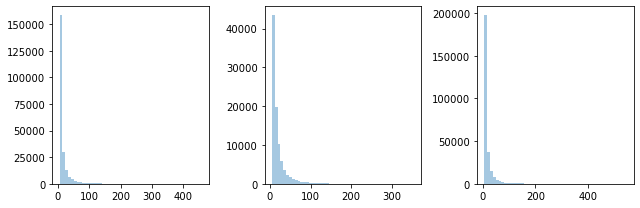

In [27]:
fn_exp2_narrowPeak = sorted(glob.glob("./processed_data/ILC2_ATAC_mouse_rep*narrowPeak"))

#Read narrowPeak files into pandas dataFrame
l_df_exp2_narrowPeak_size = [pd.read_csv(fn, sep = '\t', header = None) for fn in fn_exp2_narrowPeak]  

#Add names to df columns 
for df in l_df_exp2_narrowPeak_size:
    df.columns = ['chr', 'start', 'stop', 'peakName', 'score',
                  'na', 'foldChangeAtPeak', '-log10pvalue', '-log10qvalue', 'dist_to_summit']
    
#Calculate Peak sizes
exp2_narrow_peak_sizes = [df['stop'] - df['start'] for df in l_df_exp2_narrowPeak_size]

#Plot Peak sizes

fig, ax = plt.subplots(1,3, figsize=(9,3));

for idx, l_peak_sizes in enumerate(exp2_narrow_peak_sizes):
    
    sns.distplot(l_peak_sizes, ax = ax[idx], kde = False);

    plt.tight_layout()



#### Average Peak Size

In [28]:
#Print Descriptive statistics for Exp2 NarrowPeaks    
[pd.Series(list).describe() for list in exp2_narrow_peak_sizes]

#Print Average Peak sizes for three experiments 
exp2_narrowPeak_size_mean = pd.Series([pd.Series(list).describe()[1] for list in exp2_narrow_peak_sizes]).mean()

print(f'Average Peak size for Exp2: {exp2_narrowPeak_size_mean:.0f}')

Average Peak size for Exp2: 17


#### Define Union Set

In [30]:
################################
# Read in MACS2 narrowPeak files
################################

#Collect narrowPeak file names
fn_exp2_narrowPeak = sorted(glob.glob("./processed_data/ILC2_ATAC_mouse_rep*narrowPeak"))

#Read narrowPeak files into pandas dataFrame
l_df_exp2_narrowPeak = [pd.read_csv(fn, sep = '\t', header = None) for fn in fn_exp2_narrowPeak]   


###########################################
# Create summit files from narrowPeak files
###########################################

for df in l_df_exp2_narrowPeak:
    #Add names to df columns 
    df.columns = ['chr', 'start', 'stop', 'peakName', 'score',
                  'na', 'foldChangeAtPeak', '-log10pvalue', '-log10qvalue', 'dist_to_summit']
    
    #Identify the summit start coordinate
    df['start'] = df['start'] + df['dist_to_summit']
    
    #Identify the summit end coordinate
    df['stop'] = df['start'] + 1
    
    #Drop columns not need for downstream analysis 
    df.drop(columns = ['score', 'na', 'foldChangeAtPeak', '-log10qvalue', 'dist_to_summit'], inplace = True)
    
l_df_exp2_summit = l_df_exp2_narrowPeak

fn_exp2_narrowPeak

['./processed_data/ILC2_ATAC_mouse_rep1_peaks.narrowPeak',
 './processed_data/ILC2_ATAC_mouse_rep2_peaks.narrowPeak',
 './processed_data/ILC2_ATAC_mouse_rep3_peaks.narrowPeak']

In [31]:
"""
NOTES ON UNION SET METHOD:

This approach of creating a union set from replicates remedies the need to merge
overlapping ROE. Here we rank the individual ROE by SPM, and for any overlapping 
ROE found between replicates the ROE with the higher SPM value is kept.

"""

###########################################################
# Identify Union Set of Experimental Condition 1 replicates
###########################################################

# Conctenate experimental condition 1 replicate dataFrames 
df_exp2 = pd.concat(l_df_exp2_summit)

# Remove additional haplotypes
df_exp2 = df_exp2[~df_exp2.chr.str.contains("_")]

# Calculate Score Per Million
df_exp2['SPM'] = df_exp2['-log10pvalue']/(df_exp2['-log10pvalue'].sum()/1000000)

# rank experiment 1 ROE by SPM
df_exp2 = df_exp2.sort_values(by='SPM',ascending=False)

# Put window around summits
df_exp2['start'] -= int(int(win)//2)
df_exp2['stop'] += int(int(win)//2)

# Copy of df_exp2 that allows tracking of shared ROE
df_exp2_search = df_exp2[['chr','start','stop']].copy()

# Format chr column such that all values are numerical
df_exp2['chr'] = df_exp2['chr'].str.replace('chr','')
df_exp2['chr'] = df_exp2['chr'].str.replace('X','23')
df_exp2['chr'] = df_exp2['chr'].str.replace('Y','24')

df_exp2_search['chr'] = df_exp2_search['chr'].str.replace('chr','')
df_exp2_search['chr'] = df_exp2_search['chr'].str.replace('X','23')
df_exp2_search['chr'] = df_exp2_search['chr'].str.replace('Y','24')

# Typecast numerical chr column to integer
df_exp2['chr'] = df_exp2.chr.astype('int64')
df_exp2_search['chr'] = df_exp2_search.chr.astype('int64')

# Reset df_exp2 index (needed to drop ROE from df_exp2)
df_exp2.reset_index(inplace=True)
df_exp2.drop(columns = ['index'],inplace=True)

# Set up column to track number of overlap status
df_exp2_search['overlap'] = 0

# Type Cast secondary df_exp2 into ndarray (faster computation)
nd_exp2_search = df_exp2_search.values

# Establish start time for Union identification loop
start_time = time.time()

for idx, row in df_exp2.iterrows():
    # Create readable varibles for df_exp2 column names
    chr, start, stop, peakNAME, pval, spm = row
    
    # Don't search all ROE for overlap if peak has already been tagged as overlapping 
    if nd_exp2_search.item((idx,3)) == 1:
        continue
    
    # Search numpy arrary for overlapping peaks
    else:
        idx2 = np.where((\
        nd_exp2_search[:,0] == chr) & \
        (nd_exp2_search[:,1] <= start) & \
        (nd_exp2_search[:,2] >= start) | \
        (nd_exp2_search[:,0] == chr) & \
        (nd_exp2_search[:,1] <= stop) & \
        (nd_exp2_search[:,2] >= stop))

    # Tag coordinates that overlap with a peak of higher pval
    for idx in idx2[0][1:]:
        nd_exp2_search[idx,3] = 1

# Print time to identify all overlapping peaks 
print(f'Identification of all overlapping ROE runtime: {(time.time() - start_time)}')

# Capture all idx with a overlap = 1
del_idx = np.where(nd_exp2_search[:,3] == 1)[0]

# Delete overlap windows
df_exp2.drop(del_idx,inplace=True)

# Correct the chr nomenclature
df_exp2['chr'] = df_exp2.chr.astype('str')

df_exp2['chr'] = df_exp2['chr'].str.replace('23','X')

df_exp2['chr'] = df_exp2['chr'].str.replace('24','Y')

df_exp2['chr'] = 'chr' + df_exp2['chr'].astype(str)

# Output file - experimental condition union set with specified window size
df_exp2.to_csv(f'{output_dir}/{exp2_name}_union_{win}bp.bed',
                   header=None,index=False,sep='\t')

# Output file - Uniom set summit coordinates
df_exp2_out = df_exp2.copy()

df_exp2_out['start'] += int(int(win)//2) # Remove window from genomic coordinates

df_exp2_out['stop'] -= int(int(win)//2) # Remove window from genomic coordinates

df_exp2_out.to_csv(f'{output_dir}/{exp2_name}_union_summits.bed',
                       header=None,index=False,sep='\t')


Identification of all overlapping ROE runtime: 346.60282039642334


### Identification Experimental Condition 1 and 2 Union Set

In [34]:
###########################################
# Read in POS_DMSO NEG_DMSO Union set files
###########################################

#Collect union file names
fn_exp1_exp2_union_sets = [f'{output_dir}/{exp1_name}_union_summits.bed',
                           f'{output_dir}/{exp2_name}_union_summits.bed']

#Read narrowPeak files into pandas dataFrame
l_df_exp1_exp2_union_sets = [pd.read_csv(fn, sep = '\t', header = None) for fn in fn_exp1_exp2_union_sets]   

for df in l_df_exp1_exp2_union_sets:
    #Add column headers to POS/NEG Union dataFrames
    df.columns = ['chr', 'start', 'stop', 'peakName', '-log10pvalue', 'SPM']

In [35]:
"""
NOTES ON UNION SET METHOD:

This approach of creating a union set from replicates remedies the need to merge
overlapping ROE. Here we rank the individual ROE by SPM, and for any overlapping 
ROE of found between replicates the ROE with the higher SPM value is kept.

"""

#########################
# Identify Union Set 
#########################

win = 200

# Conctenate POS_DMSO NEG_DMSO Union dataFrames 
df_exp1_exp2 = pd.concat(l_df_exp1_exp2_union_sets)

# Remove additional haplotypes
df_exp1_exp2 = df_exp1_exp2[~df_exp1_exp2.chr.str.contains("_")]

# Rank DMSO union by SPM
df_exp1_exp2 = df_exp1_exp2.sort_values(by='SPM',ascending=False)

# Put emperically derived window around summits
df_exp1_exp2['start'] -= int(int(win)//2)
df_exp1_exp2['stop'] += int(int(win)//2)

# Copy of df_exp1_exp2 (allows tracking of shared ROE)
df_exp1_exp2_search = df_exp1_exp2[['chr','start','stop']].copy()

# Format chr column such that all values are numerical
df_exp1_exp2['chr'] = df_exp1_exp2['chr'].str.replace('chr','')
df_exp1_exp2['chr'] = df_exp1_exp2['chr'].str.replace('X','23')
df_exp1_exp2['chr'] = df_exp1_exp2['chr'].str.replace('Y','24')

df_exp1_exp2_search['chr'] = df_exp1_exp2_search['chr'].str.replace('chr','')
df_exp1_exp2_search['chr'] = df_exp1_exp2_search['chr'].str.replace('X','23')
df_exp1_exp2_search['chr'] = df_exp1_exp2_search['chr'].str.replace('Y','24')

# Typecast numerical chr column to integer
df_exp1_exp2['chr'] = df_exp1_exp2.chr.astype('int64')
df_exp1_exp2_search['chr'] = df_exp1_exp2_search.chr.astype('int64')

# Reset df_exp1_exp2 index (needed to drop ROE from df_exp1_exp2)
df_exp1_exp2.reset_index(inplace=True)
df_exp1_exp2.drop(columns = ['index'],inplace=True)

# Set up column to track number of overlap status
df_exp1_exp2_search['overlap'] = 0

# Type Cast secondary df_exp1_exp2 into ndarray (faster computation)
nd_exp1_exp2_search = df_exp1_exp2_search.values

#Establiosh start time for Union identification loop
start_time = time.time()

for idx, row in df_exp1_exp2.iterrows():
    #Create readable varibles for df_exp1_exp2 column names
    chr, start, stop, peakNAME, pval, spm = row
    
    #Don't search all ROE for overlap if peak has already been tagged as overlapping 
    if nd_exp1_exp2_search.item((idx,3)) == 1:
        continue
    
    #Search numpy arrary for overlapping peaks
    else:
        idx2 = np.where((\
        nd_exp1_exp2_search[:,0] == chr) & \
        (nd_exp1_exp2_search[:,1] <= start) & \
        (nd_exp1_exp2_search[:,2] >= start) | \
        (nd_exp1_exp2_search[:,0] == chr) & \
        (nd_exp1_exp2_search[:,1] <= stop) & \
        (nd_exp1_exp2_search[:,2] >= stop))

    #Tag coordinates that overlap with a peak of higher pval
    for idx in idx2[0][1:]:
        nd_exp1_exp2_search[idx,3] = 1

# Print time to identify all overlapping peaks 
print(f'Identification of all overlapping ROE runtime: {(time.time() - start_time)}')

# Capture all idx with a overlap = 1
del_idx = np.where(nd_exp1_exp2_search[:,3] == 1)[0]

# Delete overlap windows
df_exp1_exp2.drop(del_idx,inplace=True)

# Correct the chr nomenclature
df_exp1_exp2['chr'] = df_exp1_exp2.chr.astype('str')

df_exp1_exp2['chr'] = df_exp1_exp2['chr'].str.replace('23','X')

df_exp1_exp2['chr'] = df_exp1_exp2['chr'].str.replace('24','Y')

df_exp1_exp2['chr'] = 'chr' + df_exp1_exp2['chr'].astype(str)

# Output file - NEG_DMSO union set with 200bp window
df_exp1_exp2.to_csv(f'{output_dir}/{exp1_name}_{exp2_name}_union_{win}bp.bed',
               index=False,sep='\t', columns = ['peakName', 'chr', 'start', 'stop'],
              header = ['peakName', 'Chr', 'Start', 'End'])

# Output file - NEG_DMSO uniom set summit coordinates - Need for POS_DMSO NEG_DMSO union set
df_exp1_exp2_out = df_exp1_exp2.copy()

df_exp1_exp2_out['start'] += int(int(win)//2) # Remove window from genomic coordinates

df_exp1_exp2_out['stop'] -= int(int(win)//2) # Remove window from genomic coordinates

df_exp1_exp2_out.to_csv(f'{output_dir}/{exp1_name}_{exp2_name}_union_summits.bed',
                       header=None,index=False,sep='\t')

Identification of all overlapping ROE runtime: 458.17008781433105
